In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from typing import Callable, Optional
plt.rcParams['figure.figsize'] = (8, 6)
sns.set()
sns.set_context('notebook')

# Heston model

$$ dS_t = \mu S_t dt + \sqrt{v_t}S_t dW^S_t$$
$$ dv_t = \kappa (\theta - v_t)dt + \xi \sqrt{v_t} dW^v_t$$


In [126]:
def simulate_correlated_WN(n_steps, n_paths, corr=0.0, seed = None):
    if isinstance(corr, float):
        corrmat = np.array([[1, corr],
                            [corr, 1]])
    else:
        corrmat = corr
    
    if seed:
        np.random.seed(seed)

    dWs, dWv = np.random.multivariate_normal(mean = np.array([0.0, 0.0]),
                                             cov = corrmat,
                                             size = (n_paths, n_steps)).T
    return dWs, dWv


class Heston:
    def __init__(self, S0, v0, mu, rho, kappa, theta, ksi):
        self.S0 = S0
        self.v0 = v0
        self.mu = mu
        self.rho = rho
        self.kappa = kappa
        self.theta = theta
        self.ksi = ksi

        if 2*kappa*theta <= (ksi*ksi):
            raise Warning("Feller condition not met (2*kappa*theta - ksi*ksi) is not strictly positive.")
    
    @staticmethod
    def schema_full_name(abbrev):
        return {'EM': 'Euler-Maruyama', 
                'FT': 'Full truncation',
                'M': 'Milstein',
                'MFT': 'Milstein full-truncation'}[abbrev]
    
    def simulate(self, scheme, dt, n_steps=None, n_paths=None, dW = None, return_dW = False):
        
        if dW is None:
            dWs, dWv = simulate_correlated_WN(n_steps = n_steps, n_paths = n_paths, corr=model.rho)
        else:
            dWs, dWv = dW
            n_steps = dWs.shape[0]
            n_paths = dWs.shape[1]

        St, vt = np.zeros(shape=(n_steps + 1, n_paths)), np.zeros(shape=(n_steps + 1, n_paths))
        St[0, :], vt[0, :] = model.S0, model.v0

        if scheme == "EM":
            scheme_update = self.euler_maruyama_update
        elif scheme == "FT":
            scheme_update = self.full_truncation_update
        elif scheme == "M":
            scheme_update = self.milstein_update
        elif scheme == "MFT":
            scheme_update = self.milstein_full_truncation_update
        else:
            raise ValueError(f"Scheme {scheme} not recognized.")
            
        for i, (dWSi, dWvi) in enumerate(zip(dWs, dWv)):
            St[i + 1, :], vt[i + 1, :] = scheme_update(Sti = St[i, :], vti = vt[i, :],
                                                       dWSi = dWSi, dWvi = dWvi, dt = dt)

        outputs = (St, vt, dWs, dWv) if return_dW else (St, vt)
        return outputs
            
    def euler_maruyama_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = vti + self.kappa*(self.theta - vti)*dt + self.ksi*np.sqrt(vti)*dWSi*np.sqrt(dt)
        St_next = Sti + (self.mu - 0.5*vti)*dt + np.sqrt(vti)*dWvi*np.sqrt(dt)
        return St_next, vt_next
    
    def full_truncation_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = vti + self.kappa*(self.theta - np.maximum(vti, 0))*dt + self.ksi*np.sqrt(np.maximum(vti, 0))*dWSi*np.sqrt(dt)
        St_next = Sti + (self.mu - 0.5*np.maximum(vti, 0))*dt + np.sqrt(np.maximum(vti, 0))*dWvi*np.sqrt(dt)
        return St_next, vt_next

    def milstein_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = vti + self.kappa*(self.theta - vti)*dt + self.ksi*np.sqrt(vti)*dWSi*np.sqrt(dt) + self.ksi**2/4.0*(dWSi**2 - 1)*dt
        St_next = Sti + (self.mu - 0.5*vti)*dt + np.sqrt(vti)*dWvi*np.sqrt(dt)
        return St_next, vt_next  
    
    def milstein_full_truncation_update(self, Sti, vti, dWSi, dWvi, dt):
        vt_next = vti + self.kappa*(self.theta - np.maximum(vti, 0))*dt + self.ksi*np.sqrt(np.maximum(vti, 0))*dWSi*np.sqrt(dt) + self.ksi**2/4.0*(dWSi**2 - 1)*dt
        St_next = Sti + (self.mu - 0.5*np.maximum(vti, 0))*dt + np.sqrt(np.maximum(vti, 0))*dWvi*np.sqrt(dt)
        return St_next, vt_next  


# Setup the model
model = Heston(S0 = 100.0, v0 = 0.2**2,
               kappa = 2.0, ksi = 0.3, theta = 0.3**2, mu = 0.05,
               rho = -0.2)

dWs, dWv = simulate_correlated_WN(n_steps = 252, n_paths = 6, corr=model.rho, seed = 123)

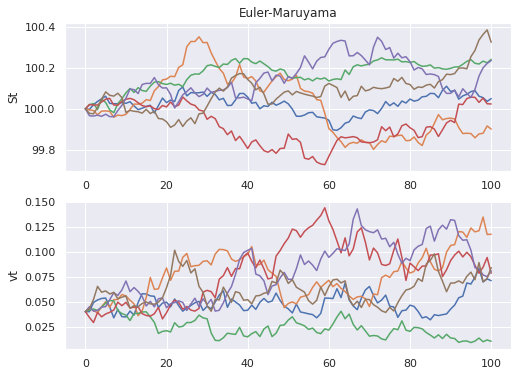

In [123]:
# Simulation setup
T = 1.0
n_steps = 100
n_paths = 6
dt = T/n_steps

dWs, dWv = simulate_correlated_WN(n_steps = n_steps, n_paths = n_paths,
                                  corr=model.rho, seed = 2022)
St, vt = model.simulate(scheme = 'EM', dW = (dWs, dWv), dt = dt)

fig, ax = plt.subplots(2, 1)
ax[0].plot(St)
ax[0].set_ylabel("St")
ax[0].set_title("Euler-Maruyama")
ax[1].plot(vt)
ax[1].set_ylabel("vt");

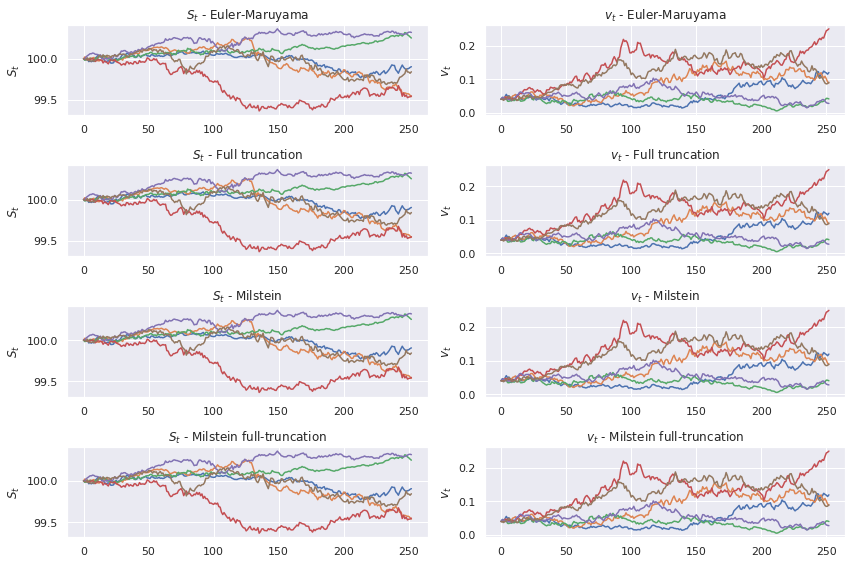

In [127]:
# Simulation setup
n_steps, n_paths = 252, 4
T = 1.0
dt = T/n_steps

fig, ax = plt.subplots(4, 2, figsize=(12, 8))

for axis, scheme in zip(ax, ['EM', 'FT', 'M', 'MFT']):
    St, vt = model.simulate(scheme = scheme, dW = (dWs, dWv), dt = dt)

    axis[0].plot(St)
    axis[0].set_ylabel("$S_t$")
    axis[0].set_title(f"$S_t$ - {model.schema_full_name(scheme)}")
    axis[1].plot(vt)
    axis[1].set_title(f"$v_t$ - {model.schema_full_name(scheme)}")
    axis[1].set_ylabel("$v_t$")
plt.tight_layout();

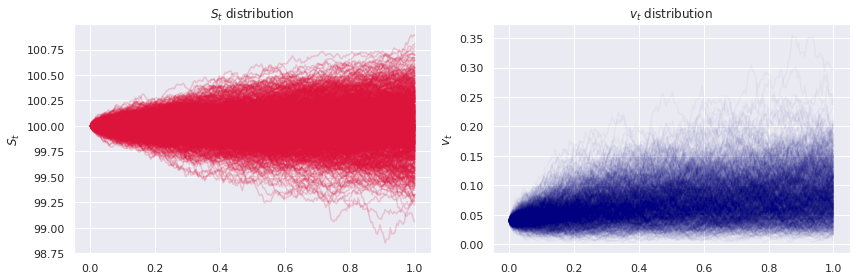

In [5]:
St, vt = model.simulate(scheme = 'FT', n_steps = 1*252, n_paths = 1000, dt = 1/252.)
t = np.linspace(0.0, 1.0, 1*252+1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t, St, color='crimson', alpha=0.2)
ax[0].set_ylabel("$S_t$")
ax[0].set_title(f"$S_t$ distribution")
ax[1].plot(t, vt, color='navy', alpha=np.sqrt(1/1000))
ax[1].set_title(f"$v_t$ distribution")
ax[1].set_ylabel("$v_t$")
plt.tight_layout();

## Simulation schemes comparison

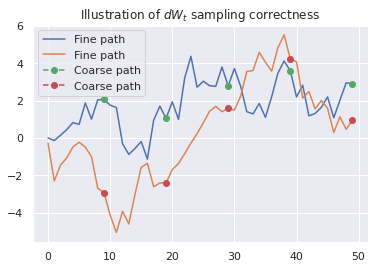

In [6]:
def get_coarse_path(fine_path, mult):
    return fine_path.reshape(-1, mult, fine_path.shape[1]).sum(axis=1)

fine_path, _ = simulate_correlated_WN(n_steps = 50, n_paths = 2, seed = 2022)

mult = 10
coarse_path = get_coarse_path(fine_path, mult)

plt.plot(fine_path.cumsum(axis=0), label='Fine path')
coarse_path_for_plot = fine_path * 0 + np.nan
coarse_path_for_plot[mult-1::mult, :] = coarse_path.cumsum(axis=0)
plt.plot(coarse_path_for_plot, linestyle = "--", marker="o", label='Coarse path')
plt.title("Illustration of $dW_t$ sampling correctness")
plt.legend();

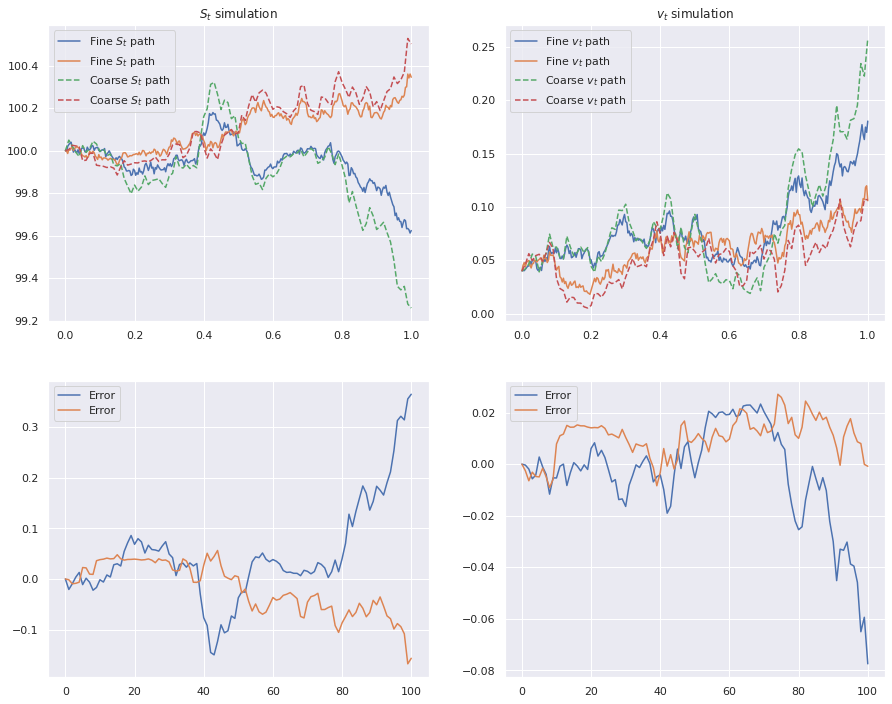

In [7]:
dWs, dWv = simulate_correlated_WN(n_steps = 300, n_paths = 2, seed = 2022)

fine_St, fine_vt = model.simulate(scheme = "EM", dW = (dWs, dWv), dt = 1./dWs.shape[0])

mult = 3
coarse_St, coarse_vt = model.simulate(scheme = "EM", dW = (get_coarse_path(fine_path, mult) for fine_path in [dWs, dWv]), dt = 1./(dWs.shape[0]/mult))

fig, ax = plt.subplots(2, 2, figsize=(15, 12))
time_axis = np.linspace(0, T, fine_St.shape[0])
ax[0][0].plot(pd.DataFrame(fine_St, index = time_axis), 
           label='Fine $S_t$ path')
ax[0][0].plot(pd.DataFrame(coarse_St, index = time_axis[::mult]), 
           label='Coarse $S_t$ path', linestyle = '--')
ax[0][0].set_title("$S_t$ simulation")
ax[0][0].legend()
ax[1][0].plot(fine_St[::mult, :] - coarse_St, label ='Error')
ax[1][0].legend()

ax[0][1].plot(pd.DataFrame(fine_vt, index = time_axis), 
           label='Fine $v_t$ path')
ax[0][1].plot(pd.DataFrame(coarse_vt, index = time_axis[::mult]), 
           label='Coarse $v_t$ path', linestyle = '--')
ax[0][1].set_title("$v_t$ simulation")
ax[0][1].legend()
ax[1][1].plot(fine_vt[::mult, :] - coarse_vt, label ='Error')
ax[1][1].legend();

## Error analysis

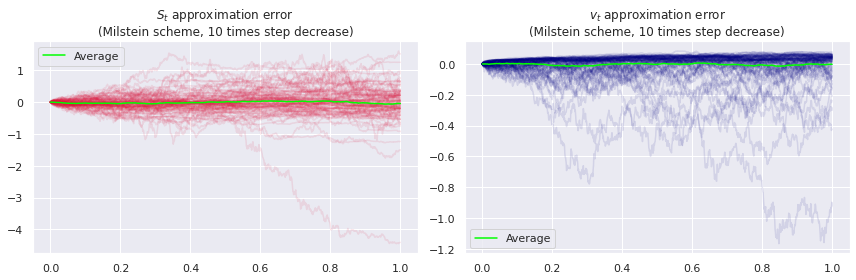

In [8]:
n_fine_steps = 10000
n_paths = 100
mult = 10
scheme = "M"

dt_fine = 1.0/n_fine_steps
dt_coarse = 1.0/(n_fine_steps/mult)

dW_fine = simulate_correlated_WN(n_steps = n_fine_steps, n_paths = n_paths, seed = 2022)
dW_coarse = (get_coarse_path(fine_path, mult) for fine_path in dW_fine)

sim_fine = model.simulate(scheme = 'FT', dW = dW_fine, dt = dt_fine)
sim_coarse = model.simulate(scheme = "FT", dW = dW_coarse, dt = dt_coarse)
t_fine = np.linspace(0.0, 1.0, sim_fine[0].shape[0])
t_coarse = np.linspace(0.0, 1.0, sim_coarse[0].shape[0])

diffs = [paths_fine[0::mult, :] - paths_coarse for paths_fine, paths_coarse in zip(sim_fine, sim_coarse)]

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(t_coarse, diffs[0], color='crimson', alpha=np.sqrt(1/n_paths))
ax[0].plot(t_coarse, diffs[0].mean(axis=1), color = "lime", label = 'Average')
ax[0].set_title(f"$S_t$ approximation error\n({model.schema_full_name(scheme)} scheme, {mult} times step decrease)")
ax[0].legend()

ax[1].plot(t_coarse, diffs[1], color='navy', alpha=np.sqrt(1/n_paths))
ax[1].plot(t_coarse, diffs[1].mean(axis=1), color = "lime", label = 'Average')
ax[1].set_title(f"$v_t$ approximation error\n({model.schema_full_name(scheme)} scheme, {mult} times step decrease)")
ax[1].legend()

plt.tight_layout();

In [140]:
def get_weak_error(fine_path, coarse_path):
  errs = fine_path[-1, :] - coarse_path[-1, :]
  return np.nanmean(np.abs(errs))

def get_strong_error(fine_path, coarse_path):
  mult = (fine_path.shape[0] - 1)/(coarse_path.shape[0] - 1)
  errs = fine_path[0::int(mult), :] - coarse_path
  return np.sqrt(np.nanmean(errs**2))

print(f"""
Weak error: {get_weak_error(sim_fine[0], sim_coarse[0]):.4f}
Strong error: {get_strong_error(sim_fine[0], sim_coarse[0]):.4f}""")


Weak error: 0.6366
Strong error: 0.5201


In [116]:
n_fine_steps = 10000
n_paths = 1000
scheme = "EM"

dW_fine = simulate_correlated_WN(n_steps = n_fine_steps, n_paths = n_paths)
sim_fine = model.simulate(scheme = scheme, dW = dW_fine, dt = dt_fine)

mult = 2500 #, 2500, 2000, 1000, 500, 250, 200, 100, 50, 25, 20, 10]:
dt_fine = 1.0/n_fine_steps
dt_coarse = 1.0/(n_fine_steps/mult)

dW_coarse = (get_coarse_path(fine_path, mult) for fine_path in dW_fine)
sim_coarse = model.simulate(scheme = scheme, dW = dW_coarse, dt = dt_coarse)

errs = [dt_coarse, get_weak_error(sim_fine[1], sim_coarse[1])]
errs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in sqrt


[0.25, 20.599173791102444]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in sqrt


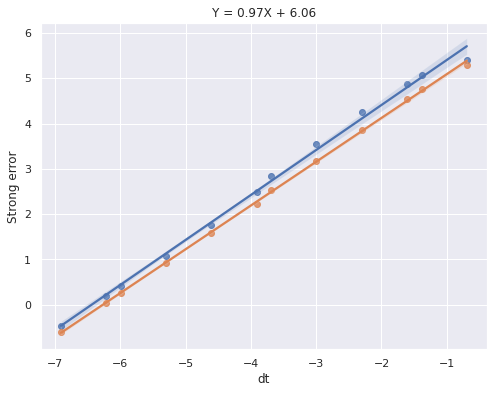

In [142]:
n_fine_steps = 10000
n_paths = 1000
scheme = "M"

dW_fine = simulate_correlated_WN(n_steps = n_fine_steps, n_paths = n_paths)
sim_fine = model.simulate(scheme = scheme, dW = dW_fine, dt = dt_fine)

errs = {}
for mult in [5000, 2500, 2000, 1000, 500, 250, 200, 100, 50, 25, 20, 10]:
  dt_fine = 1.0/n_fine_steps
  dt_coarse = 1.0/(n_fine_steps/mult)

  dW_coarse = (get_coarse_path(fine_path, mult) for fine_path in dW_fine)
  sim_coarse = model.simulate(scheme = scheme, dW = dW_coarse, dt = dt_coarse)

  errs[mult] = [dt_coarse,
                get_weak_error(sim_fine[0], sim_coarse[0]),
                get_strong_error(sim_fine[0], sim_coarse[0])]

errs = pd.DataFrame.from_dict(errs, orient='index', columns = ['dt', 'Weak error', 'Strong error'])

for err in errs.columns[1:]:
  reg = LinearRegression()
  reg.fit(X = np.log(errs['dt']).values.reshape(-1, 1), 
          y = np.log(errs[err]).values.reshape(-1, 1))

  sns.regplot(x= np.log(errs['dt']), y = np.log(errs[err]))
  plt.title(f"Y = {reg.coef_[0][0]:.2f}X + {reg.intercept_[0]:.2f}");